In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Create the Value class

In [14]:
class Value:

    def __init__(self, data, _children=(), _operator=None, label=None):
        self.data = data
        self.gradient = 0.0  # initialize gradient to 0
        self._backward = lambda: None  # function to call to backpropagate
        self._previous = set(_children)
        self._operator = _operator
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        output = Value(self.data + other.data, _children=(self, other), _operator="+")

        def _backward():
            self.gradient += output.gradient
            other.gradient += output.gradient

        output._backward = _backward
        return output

    def __mul__(self, other):
        output = Value(self.data * other.data, _children=(self, other), _operator="*")

        def _backward():
            self.gradient += other.data * output.gradient
            other.gradient += self.data * output.gradient

        output._backward = _backward
        return output

    def __sub__(self, other):
        return Value(self.data - other.data, _children=(self, other), _operator="-")

    def __truediv__(self, other):
        return Value(self.data / other.data, _children=(self, other), _operator="/")

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        output = Value(t, _children=(self,), _operator="tanh")

        def _backward():
            self.gradient += (1 - t**2) * output.gradient

        output._backward = _backward
        return output

    def backward(self):
        topo = []
        visited = set()


        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._previous:
                    build_topo(child)
                topo.append(v)


        build_topo(self)
        
        self.gradient = 1.0
        for node in reversed(topo):
            node._backward()


## Visualize the Value Graph

In [16]:
from graphviz import Digraph


def trace(root):
    # build a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            
            for child in v._previous:
                edges.add((child, v))
                build(child)

    build(root)

    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)

    for node in nodes:
        uid = str(id(node))

        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (node.label, node.data, node.gradient), shape='record')

        if node._operator:
            # if this value is a result of some operation, craete an op node for it
            dot.node(name=uid + node._operator, label=node._operator)

            # and connect this node to it
            dot.edge(uid + node._operator, uid)

    for child, parent in edges:
        # connect the child to the parent
        dot.edge(str(id(child)), str(id(parent)) + parent._operator)

    return dot


## Backpropagation with a Neuron

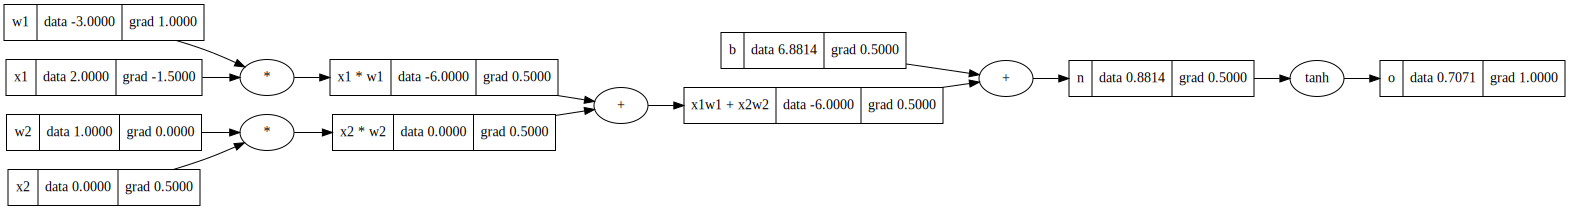

In [24]:
# inputs of neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of neuron
b = Value(6.8813735870195432, label='b')

# compute the neuron
# n = x1 * w1 + x2 * w2 + b
x1w1 = x1 * w1
x1w1.label = "x1 * w1"

x2w2 = x2 * w2
x2w2.label = "x2 * w2"

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b
n.label = "n"

# activation function (tanh)
o = n.tanh()
o.label = "o"

# backprop
o.backward()

draw_dot(o)